In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import sympy as smp
from math import ceil, floor

## Propeller data

In [2]:
D = 11 * 25.4 / 1000 # diameter in meters
pitch = 8
rho = 1.225 # air density
Va = 18 # horizontal flight velocity
DS = np.loadtxt('Static.txt', dtype=float, skiprows=1)
Oms = DS[:, 0]
cts = DS[:, 1]
cqs = DS[:, 2] / (2 * np.pi)
pcqs = np.polyfit(Oms, cqs, 2)

D3 = np.loadtxt('3000RPM.txt', dtype=float, skiprows=1)
J3 = D3[:, 0]
ct3 = D3[:, 1]
cq3 = D3[:, 2] / (2 * np.pi)
eta3 = D3[:, 3]

D4 = np.loadtxt('4000RPM.txt', dtype=float, skiprows=1)
J4 = D4[:, 0]
ct4 = D4[:, 1]
cq4 = D4[:, 2] / (2 * np.pi)
eta4 = D4[:, 3]

D5 = np.loadtxt('5000RPM.txt', dtype=float, skiprows=1)
J5 = D5[:, 0]
ct5 = D5[:, 1]
cq5 = D5[:, 2] / (2 * np.pi)
eta5 = D5[:, 3]

D6 = np.loadtxt('6000RPM.txt', dtype=float, skiprows=1)
J6 = D6[:, 0]
ct6 = D6[:, 1]
cq6 = D6[:, 2] / (2 * np.pi)
eta6 = D6[:, 3]

Ct = np.concatenate((ct3, ct4), axis=0)
Ct = np.concatenate((Ct, ct5), axis=0)
Ct = np.concatenate((Ct, ct6), axis=0)

Cq = np.concatenate((cq3, cq4), axis=0)
Cq = np.concatenate((Cq, cq5), axis=0)
Cq = np.concatenate((Cq, cq6), axis=0)

J = np.concatenate((J3, J4), axis=0)
J = np.concatenate((J, J5), axis=0)
J = np.concatenate((J, J6), axis=0)

eta = np.concatenate((eta3, eta4), axis=0)
eta = np.concatenate((eta, eta5), axis=0)
eta = np.concatenate((eta, eta6), axis=0)

## Motor Data

In [3]:
MD = np.loadtxt('D:/Education/SKAT2025/KB-102_SKAT_2025/СиловаяУстановка/X2814.txt', dtype= float, skiprows=1)
i0 = float(MD[0, 2])
R = float(MD[0, 1])
kv = MD[0,0] # RPM/volts
kv = float(2*np.pi * kv /60 ) # Volts/(rad/sec)
kq = float(1/kv)
kv = kv**-1
MD, kv, kq

(array([[9.00e+02, 3.36e-02, 1.20e+00, 1.08e-01],
        [1.00e+03, 3.55e-02, 1.30e+00, 1.13e-01],
        [1.20e+03, 2.13e-02, 1.70e+00, 1.10e-01]]),
 0.01061032953945969,
 0.01061032953945969)

## Functions

In [4]:
pcq = np.polyfit(J, Cq, 2)
pcq3 = np.polyfit(J3, cq3, 2)
pcq4 = np.polyfit(J4, cq4, 2)
pcq5 = np.polyfit(J5, cq5, 2)
pcq6 = np.polyfit(J6, cq6, 2)
pct = np.polyfit(J, Ct, 2)
pct3 = np.polyfit(J3, ct3, 2)
pct4 = np.polyfit(J4, ct4, 2)
pct5 = np.polyfit(J5, ct5, 2)
pct6 = np.polyfit(J6, ct6, 2)
peta = np.polyfit(J, eta, 2)

def GetAR(Om, V):
    om = Om * 2 * np.pi / 60
    return 2*np.pi*V/(om * D)

def GetOmega(AR, V): 
    return (2 * np.pi * V / (D * AR)) / (2 * np.pi) * 60

def GetMTorque(Om, Vin):
    om = Om * 2 * np.pi / 60
    return kv*((Vin - kv*om)/R - i0)

def GetTorque(Om, V):
    om = Om * 2 * np.pi / 60
    r = om
    for i in range(np.size(Om)):
        if Om[i] < 3500:
            r[i] = rho * D**5 * om[i]**2 * np.polyval(pcq3, GetAR(Om[i], V)) / (4 * np.pi**2)
        elif Om[i] < 4500 and Om[i] >= 3500:
            r[i] = rho * D**5 * om[i]**2 * np.polyval(pcq4, GetAR(Om[i], V)) / (4 * np.pi**2)
        elif Om[i] < 5500 and Om[i] >= 4500:
            r[i] = rho * D**5 * om[i]**2 * np.polyval(pcq5, GetAR(Om[i], V)) / (4 * np.pi**2)
        elif Om[i] >= 5500:
            r[i] = rho * D**5 * om[i]**2 * np.polyval(pcq6, GetAR(Om[i], V)) / (4 * np.pi**2)
    return r

def GetThrust(Om, V):
    om = Om * 2 * np.pi / 60
    r = om
    for i in range(np.size(Om)):
        if Om[i] < 3500:
            r[i] = rho * D**4 * om[i]**2 * np.polyval(pct3, GetAR(Om[i], V)) / (4 * np.pi**2)
        if Om[i] < 4500 and Om[i] >= 3500:
            r[i] = rho * D**4 * om[i]**2 * np.polyval(pct4, GetAR(Om[i], V)) / (4 * np.pi**2)
        if Om[i] < 5500 and Om[i] >= 4500:
            r[i] = rho * D**4 * om[i]**2 * np.polyval(pct5, GetAR(Om[i], V)) / (4 * np.pi**2)
        if Om[i] >= 5500:
            r[i] = rho * D**4 * om[i]**2 * np.polyval(pct6, GetAR(Om[i], V)) / (4 * np.pi**2)
    return r

def GetCurrent(Om, Vin):
    om = Om * 2 * np.pi / 60
    return (Vin - om*kv)/R

def GetPower(Om, V):
    om = Om * 2 * np.pi / 60
    return GetTorque(Om, V) * om

# def GetMEff(Om, Vin, Va):
#     om = Om * 2 * np.pi / 60
#     return GetPower(Om, Va)/ (GetCurrent(Om, Vin) * Vin) 

def GetMEff(Om, Vin):
    om = Om * 2 * np.pi / 60
    i = (Vin - kv*om)/R
    return (1 - i0/i)*kq/(kv*(1 + i*R/(kv*om))) 

def GetMPower(Vin, Om):
    om  = Om * 2 * np.pi / 60
    return Vin * ((Vin - kv*om)/R + i0)

def GetVoltage(Om, Va):
    v = smp.symbols('v', real=True, positive=True)
    Qp = GetTorque(Om, Va)
    Qm = GetMTorque(Om, v)
    return smp.solve(Qm-Qp, v)[v]

def GetRPM(Va, target):
    Omega = np.linspace(3000, 10000, 10000)
    for el in Omega:
        Th = GetThrust(np.array([el]), Va)
        if abs(Th - target) <= 0.01:
            return el
        
def GetPitchSpeed(Om, Va):
    om = Om * 2 * np.pi / 60
    return Om/1056 * pitch * 1.609 / 3.6


GetMTorque(6200, 7.53), GetTorque(np.array([6200]), 17), GetPower(np.array([6200]), 17), GetVoltage(np.array([6200]), 17)

(0.1897199902758042,
 array([0.15105348]),
 array([98.07335763]),
 7.40755378160472)

(array([-0.10176657, -0.05878589,  0.12229237]),
 array([-0.01978222,  0.01143496,  0.00650642]))

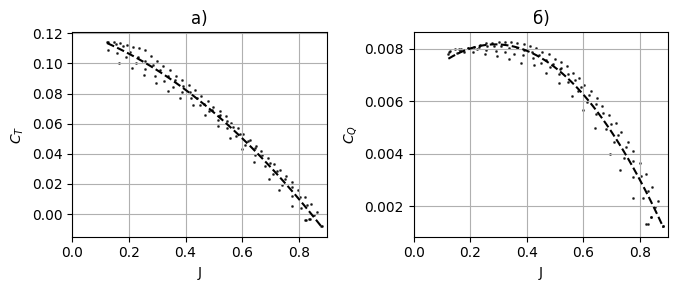

In [5]:
fig1, ax1 = plt.subplots(1,2, figsize=(87.4*2/25.4, 3))
fig1.set_layout_engine('tight')
ax1 = ax1.ravel()
ax1[0].scatter(J, Ct, s=1, c='black', alpha=0.7)
ax1[0].plot(np.linspace(np.min(J), np.max(J)), np.polyval(pct, np.linspace(np.min(J), np.max(J))), '--', c='black')
ax1[0].set_xlabel('J')
ax1[0].set_ylabel(r'$C_T$')
ax1[0].grid('Major')
ax1[0].set_title('a)')
ax1[1].set_title('б)')
ax1[0].set_xlim(0, 0.9)
ax1[1].scatter(J, Cq, s=1, c='black', alpha=0.7)
ax1[1].plot(np.linspace(np.min(J), np.max(J)), np.polyval(pcq, np.linspace(np.min(J), np.max(J))), '--', c='black')
ax1[1].set_xlabel('J')
ax1[1].set_ylabel(r'$C_Q$')
ax1[1].grid('Major')
ax1[1].set_xlim(0, 0.9)
# plt.savefig("CoefficientsAeroNaut11x8.png", dpi=300, bbox_inches = 'tight', pad_inches=0.01)
pct, pcq

7.101622958390431
5000 7500


(np.float64(5992.799279927993),
 np.float64(0.12714619728713394),
 np.float64(102.14439554814952),
 np.float64(0.8522788926184459))

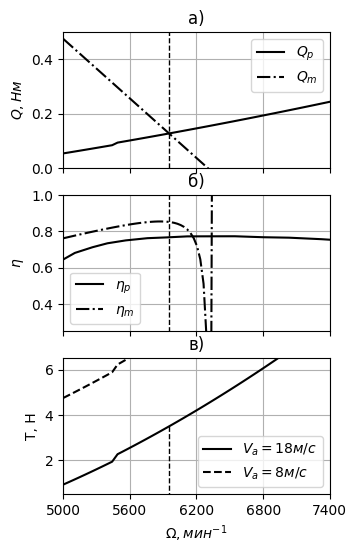

In [6]:
fig2, ax2 = plt.subplots(3,1, figsize=(87.4 /25.4, 6))
ax2.ravel()
Va = 18
TargetThrust = 3.5
RPM = GetRPM(Va, TargetThrust)
Vin = float(GetVoltage(np.array([RPM]), Va))
print(Vin)

xl = int((RPM - 1250) // 1000) + 1 
xl *= 1000 
xu = int(xl +  5 * 500) 
print(xl, xu)


ax2[0].plot(np.linspace(xl, xu), GetTorque(np.linspace(xl, xu), Va), label = r'$Q_{p}$', color='black')
ax2[0].plot(np.linspace(xl, xu), GetMTorque(np.linspace(xl, xu), Vin), '-.',label = r'$Q_{m}$', color='black')
ax2[0].vlines(RPM, 0, 1, linestyle='--', color='black', linewidth=1)
ax2[0].set_ylim(0, 0.5)
ax2[0].set_ylabel(r'$Q, Нм$')
ax2[0].set_xticks(ticks = np.linspace(xl, xu, 5), labels = [' ', ' ', ' ', ' ', ' '], color='w')
ax2[0].set_xlim(xl, xu)
ax2[0].grid('Major')
ax2[0].legend()
ax2[0].set_title('a)')

ax2[1].plot(GetOmega(J6, Va), eta6, label = r'$\eta_{p}$', color='black')
ax2[1].vlines(RPM, 0, 1, linestyle='--', color='black', linewidth=1)
ax2[1].plot(np.linspace(xl, xu-1000), GetMEff(np.linspace(xl, xu-1000), Vin), '-.',label = r'$\eta_{m}$', color='black')
ax2[1].set_ylim(0.25, 1)
ax2[1].set_xlim(xl, xu)
ax2[1].set_ylabel(r'$\eta$')
ax2[1].set_xticks(ticks = np.linspace(xl, xu, 5), labels = [' ', ' ', ' ', ' ', ' '], color='w')
ax2[1].grid('Major')
ax2[1].legend()
ax2[1].set_title('б)')

ax2[2].plot(np.linspace(xl, xu), GetThrust(np.linspace(xl, xu), Va), color='black', label=r'$V_a = {} м/с$'.format(Va))
ax2[2].plot(np.linspace(xl, xu), GetThrust(np.linspace(xl, xu), 8), '--', color='black', label=r'$V_a = 8 м/с$')
ax2[2].vlines(RPM, 0, TargetThrust, linestyle='--', color='black', linewidth=1)
ax2[2].set_ylim(TargetThrust - 3, TargetThrust + 3)
ax2[2].set_xlim(xl, xu)
ax2[2].set_ylabel('T, Н')
# ax2[2].set_yticks(ticks = [0, 1, 2, 3, 4, 5, 6], labels = ['0', '1','2','3','4','5','6'])
ax2[2].set_xticks(ticks = np.linspace(xl, xu, 5), labels = [str(xl + i*600) for i in range(5)])
ax2[2].grid('Major')
ax2[2].set_xlabel(r'$\Omega, мин^{-1}$')
ax2[2].set_title('в)')
ax2[2].legend()
# plt.savefig('MotorMatching.png', dpi=300, bbox_inches='tight', pad_inches = 0)
RPM, GetMTorque(RPM, Vin), GetMPower(Vin, RPM), GetMEff(RPM, Vin)

In [ ]:
V = np.linspace(0, 25, 100)
T = []
for el in V:
    T.append(GetThrust(np.array([7000]), el))

np.savetxt()

[array([12.99471485]),
 array([12.94461438]),
 array([12.89332848]),
 array([12.84085717]),
 array([12.78720043]),
 array([12.73235827]),
 array([12.67633069]),
 array([12.61911768]),
 array([12.56071926]),
 array([12.50113541]),
 array([12.44036614]),
 array([12.37841145]),
 array([12.31527134]),
 array([12.25094581]),
 array([12.18543485]),
 array([12.11873848]),
 array([12.05085668]),
 array([11.98178946]),
 array([11.91153682]),
 array([11.84009875]),
 array([11.76747527]),
 array([11.69366636]),
 array([11.61867203]),
 array([11.54249228]),
 array([11.46512711]),
 array([11.38657652]),
 array([11.3068405]),
 array([11.22591907]),
 array([11.14381221]),
 array([11.06051993]),
 array([10.97604223]),
 array([10.8903791]),
 array([10.80353056]),
 array([10.71549659]),
 array([10.6262772]),
 array([10.53587239]),
 array([10.44428216]),
 array([10.35150651]),
 array([10.25754543]),
 array([10.16239894]),
 array([10.06606702]),
 array([9.96854968]),
 array([9.86984692]),
 array([9.769958

FileNotFoundError: C:/Users/PC/Education/SKAT2025/KB-102_SKAT_2025/ПромежуточныйДизайн/СиловаяУстановка/test.txt not found.

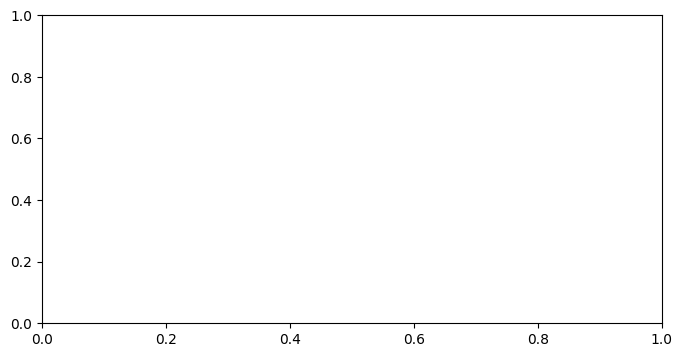

In [7]:
# AT2820 torque coef for 11x7 and 12x6
fig3, ax3 = plt.subplots(1,1, figsize=(8,4))
test = np.loadtxt('C:/Users/PC/Education/SKAT2025/KB-102_SKAT_2025/ПромежуточныйДизайн/СиловаяУстановка/test.txt', dtype= float)
test2 = np.loadtxt('C:/Users/PC/Education/SKAT2025/KB-102_SKAT_2025/ПромежуточныйДизайн/СиловаяУстановка/test2.txt', dtype= float)
curr = test[:, 2]
torq = test[:, 5]
coef = torq/curr

pkq = np.polyfit(curr, coef, 2)
fpkq = interp1d(curr, coef, 'linear')

curr2 = test2[:, 2]
torq2 = test2[:, 5]
coef2= torq2/curr2

test3 = np.loadtxt('C:/Users/PC/Education/SKAT2025/KB-102_SKAT_2025/ПромежуточныйДизайн/СиловаяУстановка/test3.txt', dtype= float)
curr3 = test3[:, 2]
torq3 = test3[:, 5]
coef3 = torq3/curr3
ax3.scatter(curr, coef, label = '11x7')
ax3.plot(curr, np.polyval(pkq, curr), label = '11x7')
ax3.plot(curr, fpkq(curr), label = '11x7')
# ax3.plot(curr2, coef2, label = '12x6')
# ax3.plot(curr3, coef3, label = '13x6.5')
ax3.legend()
np.mean(coef), np.std(coef)